# Lista 4

Para esta lista, utilizei o kernel do Colab no VSCode, para poder aproveitar do poder computacional de uma GPU, que não tenho no meu notebook

O Colab já tem quase todos os pacotes que necessito instalado, faltando apenas o optuna:

In [ ]:
!pip install optuna

Carregando as bibliotecas

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import optuna
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import copy

Como utilizei o kernel Colab, é muito mais simples hospedar os dados na nuvem, para que ele consiga buscá-los e ler diretamente.

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/penasta/rna1/refs/heads/main/dados/dados.csv')

OBS: gerei estes dados no R, utilizando a seed sugerida pelo professor, para garantir a confiabilidade dos resultados.

O código para geração de dados idênticos se encontram neste [link](https://github.com/penasta/rna1/blob/main/rdocs/gerar_dados.r)

Fazendo a separação treino-teste-validação como nas últimas listas, para comparabilidade

In [ ]:
X = df[['x1.obs', 'x2.obs']].to_numpy().T

Y = df[['y']].to_numpy().T

x_treino = X[:, 0:8000]
x_val = X[:, 8000:9000]
x_teste = X[:, 9000:10000]

y_treino = Y[:, 0:8000]
y_val = Y[:, 8000:9000]
y_teste = Y[:, 9000:10000]

Verificando os formatos

In [5]:
print("X:", X.shape)
print("Y:", Y.shape)
print("Treino:", x_treino.shape, y_treino.shape)
print("Validação:", x_val.shape, y_val.shape)
print("Teste:", x_teste.shape, y_teste.shape)

X: (2, 100000)
Y: (1, 100000)
Treino: (2, 8000) (1, 8000)
Validação: (2, 1000) (1, 1000)
Teste: (2, 1000) (1, 1000)


# Item a)

In [6]:
x_treino_t = torch.tensor(x_treino.T, dtype=torch.float32)
y_treino_t = torch.tensor(y_treino.T, dtype=torch.float32).view(-1,1)

x_val_t = torch.tensor(x_val.T, dtype=torch.float32)
y_val_t = torch.tensor(y_val.T, dtype=torch.float32).view(-1,1)

In [7]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2, 2)
        self.out    = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()
        
        nn.init.zeros_(self.hidden.weight)
        nn.init.zeros_(self.hidden.bias)
        nn.init.zeros_(self.out.weight)
        nn.init.zeros_(self.out.bias)

    def forward(self, x):
        h = self.sigmoid(self.hidden(x))
        y_hat = self.out(h)
        return y_hat

In [8]:
Phi = SimpleNN()

criterion = nn.MSELoss()
optimizer = optim.SGD(Phi.parameters(), lr=0.1)
epochs = 100

losses_treino = []
losses_val = []
best_val_loss = np.inf
best_state = None
best_epoch = 0

In [9]:
for epoch in range(epochs):

    optimizer.zero_grad()
    y_pred = Phi(x_treino_t)
    train_loss = criterion(y_pred, y_treino_t)
    train_loss.backward()
    optimizer.step()

    with torch.no_grad():
        val_pred = Phi(x_val_t)
        val_loss = criterion(val_pred, y_val_t)

    losses_treino.append(train_loss.item())
    losses_val.append(val_loss.item())

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_state = {k: v.clone() for k, v in Phi.state_dict().items()}
        best_epoch = epoch + 1

In [10]:
print(f"Melhor época (validação): {best_epoch}")
print(f"Melhor MSE de validação: {best_val_loss:.6f}")

Melhor época (validação): 100
Melhor MSE de validação: 97.893570


Estes resultados estranhamente diferem do gabarito, mas batem com os resultados que eu encontrei na lista 2. Então, se fiz algo errado lá, fiz exatamente igual nesta lista, pois bateram os resultados tanto no R como no Python; tornando os modelos comparáveis de alguma forma

# Item b)

Configurações iniciais

In [11]:
SEED = 22025
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
n_optuna = 100
learning_rate = 0.001
qtd_epocas = 200
paciencia = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


Preparando os dados para o Torch

In [12]:
def make_loaders(X_train, y_train, X_val, y_val, X_test, y_test, device):

    X_train_t = torch.tensor(X_train.T, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train.T, dtype=torch.float32).view(-1, 1).to(device)

    X_val_t   = torch.tensor(X_val.T,   dtype=torch.float32).to(device)
    y_val_t   = torch.tensor(y_val.T,   dtype=torch.float32).view(-1, 1).to(device)

    X_test_t  = torch.tensor(X_test.T,  dtype=torch.float32).to(device)
    y_test_t  = torch.tensor(y_test.T,  dtype=torch.float32).to(device).view(-1, 1)

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
    val_loader   = DataLoader(TensorDataset(X_val_t,   y_val_t),   batch_size=64, shuffle=False)
    test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=64)

    return train_loader, val_loader, test_loader


In [13]:
train_loader, val_loader, test_loader = make_loaders(x_treino, y_treino, x_val, y_val, x_teste, y_teste, device)

Construindo a rede neural

In [14]:
def build_model(input_dim, hidden_layers, activation_name="relu", dropout=0.0):
    layers = []
    act = {
        "relu": nn.ReLU()
    }[activation_name]

    prev_dim = input_dim
    for h in hidden_layers:
        layers.append(nn.Linear(prev_dim, h))
        layers.append(act)
        if dropout > 0:
            layers.append(nn.Dropout(dropout))
        prev_dim = h

    layers.append(nn.Linear(prev_dim, 1))

    return nn.Sequential(*layers).to(device)

Definindo função objetivo do optuna para otimização de hiperparâmetros da rede

In [15]:
def objective(trial, train_loader, val_loader, input_dim):

    n_layers = trial.suggest_int("n_layers", 2, 6)
    hidden = [
        trial.suggest_int(f"n_units_layer_{i}", 8, 256, log=True)
        for i in range(n_layers)
    ]

    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    lr = trial.suggest_float("lr", 3e-5, 3e-3, log=True)

    model = build_model(
        input_dim=input_dim,
        hidden_layers=hidden,
        activation_name="relu",
        dropout=dropout
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    best_val = float("inf")
    patience = paciencia
    patience_count = 0

    for epoch in range(qtd_epocas):

        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                pred = model(xb)
                val_losses.append(criterion(pred, yb).item())

        val_mse = np.mean(val_losses)

        if epoch % 5 == 0:
            trial.report(val_mse, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

        if val_mse < best_val:
            best_val = val_mse
            patience_count = 0
        else:
            patience_count += 1
            if patience_count >= patience:
                break

    return best_val


Otimizando

In [16]:
pruner = optuna.pruners.HyperbandPruner()
study = optuna.create_study(direction="minimize", pruner=pruner)
study.optimize(lambda trial: objective(trial, train_loader, val_loader, input_dim=x_treino.shape[0]),
                n_trials=n_optuna,
                  show_progress_bar=True)

print("Melhores hiperparâmetros:")
print(study.best_trial.params)

[I 2025-11-23 02:36:57,320] A new study created in memory with name: no-name-c85d2280-74e1-45af-93e5-c19a8fcea5fd


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-23 02:37:22,613] Trial 0 finished with value: 111.23853206634521 and parameters: {'n_layers': 6, 'n_units_layer_0': 163, 'n_units_layer_1': 126, 'n_units_layer_2': 9, 'n_units_layer_3': 22, 'n_units_layer_4': 43, 'n_units_layer_5': 14, 'dropout': 0.47935819802454194, 'weight_decay': 0.00018693781661057758, 'lr': 0.0007753603589791862}. Best is trial 0 with value: 111.23853206634521.
[I 2025-11-23 02:38:10,057] Trial 1 finished with value: 4.869601458311081 and parameters: {'n_layers': 3, 'n_units_layer_0': 65, 'n_units_layer_1': 82, 'n_units_layer_2': 15, 'dropout': 0.3022739617633364, 'weight_decay': 4.037145961447963e-06, 'lr': 0.001741569496790645}. Best is trial 1 with value: 4.869601458311081.
[I 2025-11-23 02:38:49,427] Trial 2 finished with value: 107.1932954788208 and parameters: {'n_layers': 6, 'n_units_layer_0': 131, 'n_units_layer_1': 9, 'n_units_layer_2': 87, 'n_units_layer_3': 10, 'n_units_layer_4': 23, 'n_units_layer_5': 23, 'dropout': 0.37498906325856457, 'wei

Loop para treinar a rede com o melhor conjunto de hiperparâmetros

In [17]:
def train_and_eval(model, optimizer, criterion, train_loader=train_loader, val_loader=val_loader, n_epochs=qtd_epocas):
    for epoch in range(n_epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                pred = model(xb)
                val_losses.append(criterion(pred, yb).item())

    return print(f"MSE no conjunto de validação: {np.mean(val_losses):.6f}")


Re-treinando o modelo final com os melhores hiperparâmetros

In [19]:
best_params = study.best_trial.params

hidden = [best_params[f"n_units_layer_{i}"] for i in range(best_params["n_layers"])]

best_model = build_model(
    input_dim=x_treino.shape[0],
    hidden_layers=hidden,
    activation_name="relu",
    dropout=best_params["dropout"]
)

optimizer = optim.Adam(
    best_model.parameters(),
    lr=best_params["lr"],
    weight_decay=best_params["weight_decay"]
)

criterion = nn.MSELoss()

train_and_eval(best_model, optimizer, criterion)

MSE no conjunto de validação: 1.290015


Avaliação final no conjunto de teste

In [20]:
best_model.eval()
test_losses = []
with torch.no_grad():
    for xb, yb in test_loader:
        pred = best_model(xb)
        test_losses.append(((pred - yb)**2).mean().item())

final_test_mse = np.mean(test_losses)
print(f"MSE no conjunto de teste: {final_test_mse:.6f}")

MSE no conjunto de teste: 1.442020


# Item c)

In [21]:
best_model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        preds = best_model(xb)
        y_true.extend(yb.cpu().numpy().flatten())
        y_pred.extend(preds.cpu().numpy().flatten())

In [22]:
df_plot = pd.DataFrame({
    "y_true": y_true,
    "y_pred": y_pred
})

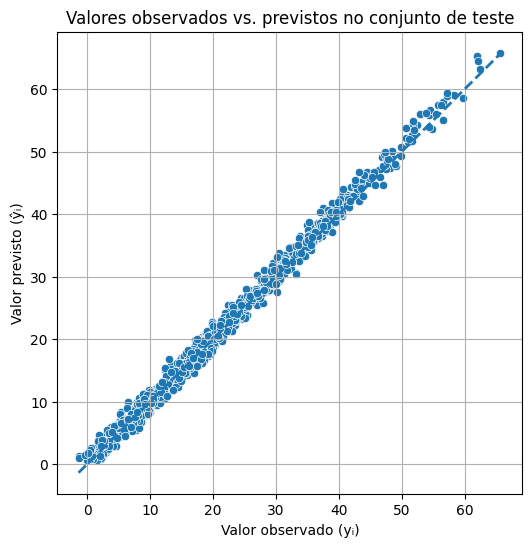

In [23]:
plt.figure(figsize=(6,6))
sns.scatterplot(x="y_true", y="y_pred", data=df_plot)

lims = [
    min(df_plot.y_true.min(), df_plot.y_pred.min()),
    max(df_plot.y_true.max(), df_plot.y_pred.max())
]
plt.plot(lims, lims, "--", linewidth=2)

plt.xlabel("Valor observado (yᵢ)")
plt.ylabel("Valor previsto (ŷᵢ)")
plt.title("Valores observados vs. previstos no conjunto de teste")
plt.grid(True)
plt.show()

Na lista anterior, o gráfico de valores observados vs previstos apresentava sérias limitações e imperfeições em relação a linha de 45 graus esperada. Existia um limite inferior e superior que as predições não conseguiam ultrapassar. Desta vez, a rede praticamente crava com os verdadeiros valores.

# Item d)

In [24]:
best_model.eval()

x_input = torch.tensor([[1.0, 1.0]], dtype=torch.float32).to(device)

with torch.no_grad():
    y_pred = best_model(x_input)

print("Predição para (x1=1, x2=1):", y_pred.item())

Predição para (x1=1, x2=1): 14.711983680725098


Note: O valor analítico neste caso seria $Y \sim N(\mu,1)$, onde $\mu= |1^3 - 30*sin(1) + 10| \approx 14,24413$. Pode-se dizer que a rede cravou!

# item e)

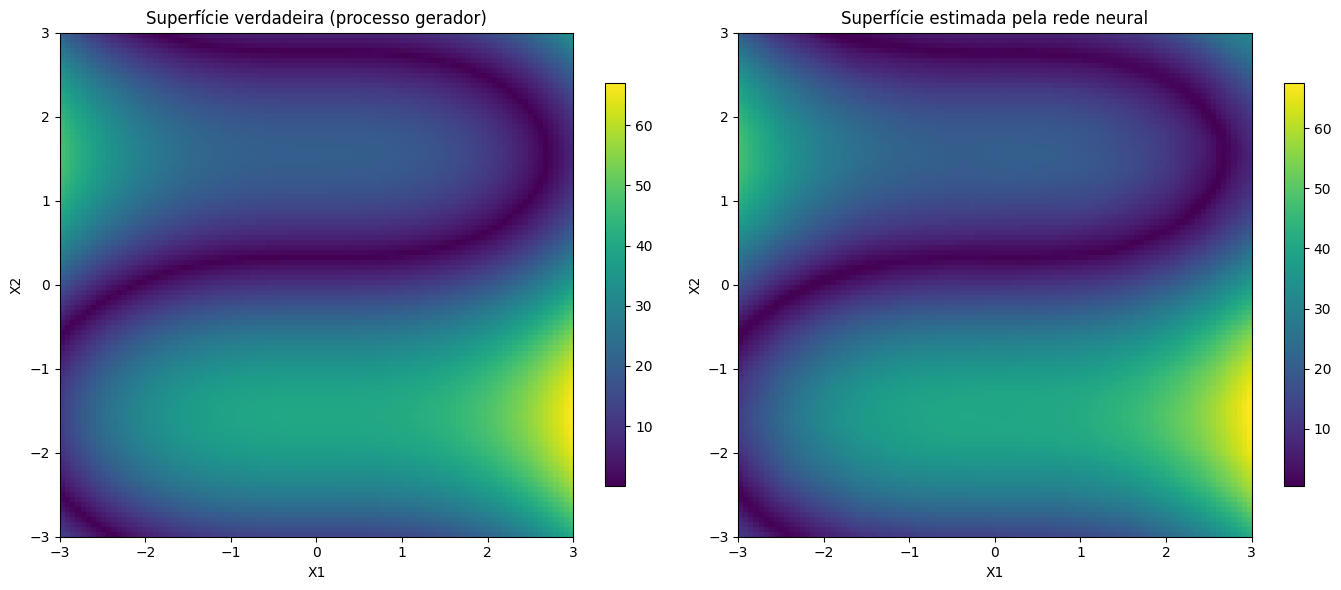

In [25]:
n = 100
x1_lin = np.linspace(-3, 3, n)
x2_lin = np.linspace(-3, 3, n)

X1g, X2g = np.meshgrid(x1_lin, x2_lin)

Y_true = np.abs(X1g**3 - 30*np.sin(X2g) + 10)

grid_points = np.column_stack([X1g.ravel(), X2g.ravel()])
grid_tensor = torch.tensor(grid_points, dtype=torch.float32).to(device)

best_model.eval()
with torch.no_grad():
    y_grid_pred = best_model(grid_tensor).cpu().numpy().flatten()

Y_pred = y_grid_pred.reshape(n, n)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

im0 = axes[0].imshow(
    Y_true,
    extent=[-3, 3, -3, 3],
    origin="lower",
    cmap="viridis",
    aspect="auto"
)
axes[0].set_title("Superfície verdadeira (processo gerador)")
axes[0].set_xlabel("X1")
axes[0].set_ylabel("X2")
fig.colorbar(im0, ax=axes[0], shrink=0.8)

im1 = axes[1].imshow(
    Y_pred,
    extent=[-3, 3, -3, 3],
    origin="lower",
    cmap="viridis",
    aspect="auto"
)
axes[1].set_title("Superfície estimada pela rede neural")
axes[1].set_xlabel("X1")
axes[1].set_ylabel("X2")
fig.colorbar(im1, ax=axes[1], shrink=0.8)

plt.tight_layout()
plt.show()


Pela comparação visual dos gráficos, pode-se observar que a rede praticamente aprendeu o processo gerador, sendo até difícil apontar, sem a legenda, qual o gráfico do processo gerador e qual o gráfico dos valores estimados pela rede

# item f)

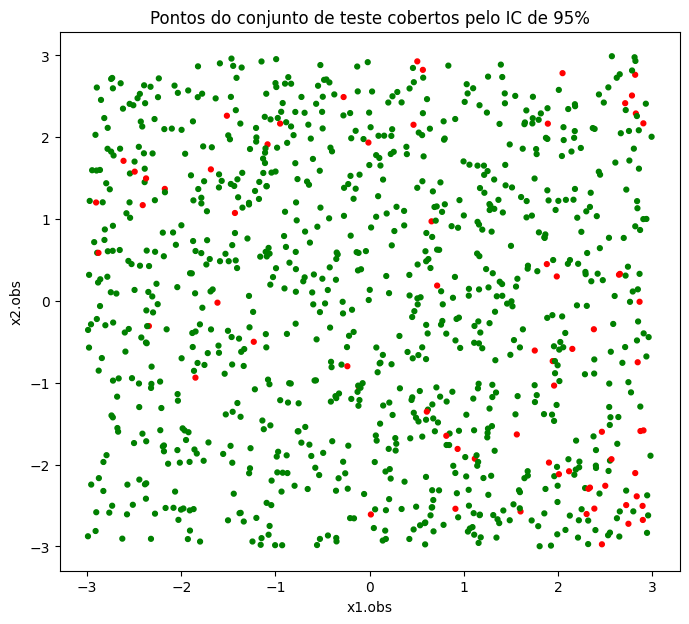

In [26]:
best_model.eval()

val_losses = []
criterion = nn.MSELoss()

X_test_list = []
y_test_list = []

for xb, yb in test_loader:
    X_test_list.append(xb)
    y_test_list.append(yb)

X_test_t = torch.cat(X_test_list, dim=0)
y_test_t = torch.cat(y_test_list, dim=0)


with torch.no_grad():
    for xb, yb in val_loader:
        pred = best_model(xb)
        loss = criterion(pred, yb)
        val_losses.append(loss.item())

val_mse = np.mean(val_losses)
sigma_hat = np.sqrt(val_mse)

with torch.no_grad():
    y_pred_test = best_model(X_test_t).cpu().numpy().flatten()

y_true_test = y_test_t.cpu().numpy().flatten()

x1_test = X_test_t[:, 0].cpu().numpy()
x2_test = X_test_t[:, 1].cpu().numpy()

lower = y_pred_test - 1.96 * sigma_hat
upper = y_pred_test + 1.96 * sigma_hat

captured = (y_true_test >= lower) & (y_true_test <= upper)

plt.figure(figsize=(8, 7))

plt.scatter(
    x1_test,
    x2_test,
    c=np.where(captured, "green", "red"),
    s=12
)

plt.xlabel("x1.obs")
plt.ylabel("x2.obs")
plt.title("Pontos do conjunto de teste cobertos pelo IC de 95%")
plt.show()

Desta vez, não temos mais problemas de ajuste local como no modelo linear da lista anterior. Lá, o modelo, mesmo com um intervalo de confiança gigantesco, não conseguia capturar os valores nas regiões em que os verdadeiros valores eram mais extremos.

Note:

In [27]:
sigma_hat*1.96

np.float64(2.226144950591428)

Ou seja, o intervalo de confiança 95% da rede é minúsculo, e ainda assim consegue capturar praticamente todos os valores, com os residuais sem nenhum padrão aparente de falta de ajuste local.

# Item g)

### Treinando a rede com apenas x1

In [28]:
X1_train = x_treino[[0], :]
X1_val   = x_val[[0], :]
X1_test  = x_teste[[0], :]

train_loader_x1, val_loader_x1, test_loader_x1 = make_loaders(
    X1_train, y_treino,
    X1_val,   y_val,
    X1_test,  y_teste,
    device
)

study_x1 = optuna.create_study(direction="minimize")
study_x1.optimize(lambda trial:
    objective(trial, train_loader_x1, val_loader_x1, input_dim=X1_train.shape[0]),
    n_trials=n_optuna
)

[I 2025-11-23 03:16:07,607] A new study created in memory with name: no-name-55691faa-a64c-484c-9364-2fbafffd216e
[I 2025-11-23 03:16:40,008] Trial 0 finished with value: 178.62500381469727 and parameters: {'n_layers': 3, 'n_units_layer_0': 42, 'n_units_layer_1': 18, 'n_units_layer_2': 22, 'dropout': 0.10312466333903969, 'weight_decay': 0.0010879897615653437, 'lr': 0.00012026228619369936}. Best is trial 0 with value: 178.62500381469727.
[I 2025-11-23 03:17:09,806] Trial 1 finished with value: 178.75168132781982 and parameters: {'n_layers': 3, 'n_units_layer_0': 73, 'n_units_layer_1': 14, 'n_units_layer_2': 124, 'dropout': 0.1495167638625487, 'weight_decay': 0.007100953747262681, 'lr': 6.0323756889108536e-05}. Best is trial 0 with value: 178.62500381469727.
[I 2025-11-23 03:17:28,109] Trial 2 finished with value: 185.38785552978516 and parameters: {'n_layers': 5, 'n_units_layer_0': 67, 'n_units_layer_1': 23, 'n_units_layer_2': 136, 'n_units_layer_3': 18, 'n_units_layer_4': 214, 'dropout

### Treinando a rede com apenas x2

In [29]:
X2_train = x_treino[[1], :]
X2_val   = x_val[[1], :]
X2_test  = x_teste[[1], :]

train_loader_x2, val_loader_x2, test_loader_x2 = make_loaders(
    X2_train, y_treino,
    X2_val,   y_val,
    X2_test,  y_teste,
    device
)

study_x2 = optuna.create_study(direction="minimize")
study_x2.optimize(lambda trial:
    objective(trial, train_loader_x2, val_loader_x2, input_dim=X2_train.shape[0]),
    n_trials=n_optuna
)

[I 2025-11-23 03:39:19,743] A new study created in memory with name: no-name-fd7b1090-f6dd-4bc1-bf99-f21c2d121918
[I 2025-11-23 03:39:48,346] Trial 0 finished with value: 85.68573713302612 and parameters: {'n_layers': 2, 'n_units_layer_0': 138, 'n_units_layer_1': 123, 'dropout': 0.20595384247829235, 'weight_decay': 0.0008509846813019364, 'lr': 0.0020327241132813063}. Best is trial 0 with value: 85.68573713302612.
[I 2025-11-23 03:40:32,609] Trial 1 finished with value: 86.50057935714722 and parameters: {'n_layers': 5, 'n_units_layer_0': 13, 'n_units_layer_1': 92, 'n_units_layer_2': 8, 'n_units_layer_3': 66, 'n_units_layer_4': 70, 'dropout': 0.09214993707513353, 'weight_decay': 0.0003712506768139803, 'lr': 0.00027205653661023705}. Best is trial 0 with value: 85.68573713302612.
[I 2025-11-23 03:41:12,021] Trial 2 finished with value: 88.4015383720398 and parameters: {'n_layers': 3, 'n_units_layer_0': 52, 'n_units_layer_1': 22, 'n_units_layer_2': 13, 'dropout': 0.3685885346527223, 'weight

In [31]:
def build_hidden_list(best_params):
    n_layers = best_params["n_layers"]
    return [best_params[f"n_units_layer_{i}"] for i in range(n_layers)]


def train_final_univariate_model(study, train_loader, val_loader, n_epochs=qtd_epocas):
    
    best_params = study.best_trial.params
    hidden_list = build_hidden_list(best_params)

    model = build_model(
        input_dim=1,
        hidden_layers=hidden_list,
        activation_name="relu",
        dropout=best_params["dropout"]
    )

    optimizer = optim.Adam(
        model.parameters(),
        lr=best_params["lr"],
        weight_decay=best_params["weight_decay"]
    )

    criterion = nn.MSELoss()

    train_and_eval(
        model,
        optimizer,
        criterion,
        train_loader=train_loader,
        val_loader=val_loader,
        n_epochs=n_epochs
    )

    return model

In [32]:
model_x1 = train_final_univariate_model(
    study_x1,
    train_loader_x1,
    val_loader_x1
)

model_x2 = train_final_univariate_model(
    study_x2,
    train_loader_x2,
    val_loader_x2
)

MSE no conjunto de validação: 178.645797
MSE no conjunto de validação: 85.867234


In [33]:
def mse_model(model, test_loader):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in test_loader:
            pred = model(xb)
            losses.append(((pred - yb)**2).mean().item())
    return np.mean(losses)

mse_x1 = mse_model(model_x1, test_loader_x1)
mse_x2 = mse_model(model_x2, test_loader_x2)

print("MSE usando somente x1:", mse_x1)
print("MSE usando somente x2:", mse_x2)

MSE usando somente x1: 180.3589630126953
MSE usando somente x2: 82.07731461524963


In [34]:
def permutation_importance(model, X_test, y_test, idx_feature, n_repeats=10):
    base_X = X_test.clone()
    model.eval()

    with torch.no_grad():
        base_pred = model(base_X).cpu().numpy().flatten()
    base_mse = np.mean((base_pred - y_test.cpu().numpy().flatten())**2)

    deltas = []
    for _ in range(n_repeats):
        Xp = base_X.clone()
        perm = torch.randperm(Xp.shape[0])
        Xp[:, idx_feature] = Xp[perm, idx_feature]

        with torch.no_grad():
            pred = model(Xp).cpu().numpy().flatten()

        mse_perm = np.mean((pred - y_test.cpu().numpy().flatten())**2)
        deltas.append(mse_perm - base_mse)

    return np.mean(deltas), np.std(deltas)

In [35]:
delta_x1 = permutation_importance(best_model, X_test_t, y_test_t, idx_feature=0)
delta_x2 = permutation_importance(best_model, X_test_t, y_test_t, idx_feature=1)

delta_x1_mean = float(delta_x1[0])
delta_x2_mean = float(delta_x2[0])

print(f"x1: ΔMSE = {delta_x1_mean:.3f}")
print(f"x2: ΔMSE = {delta_x2_mean:.3f}")

x1: ΔMSE = 164.100
x2: ΔMSE = 359.123


Conclusão: x2 é mais importante que x1 para o modelo, visto que embaralhar x2 causa uma piora bem maior no desempenho do que embaralhar x1.

Se lembrarmos o nosso processo gerador:


\begin{align*}
Y & \sim N(\mu, \sigma^2=1) \\
\mu & = |X_1^3 - 30 \text{sen} (X_2) + 10| \\
X_j & \sim \text{Uniforme}(-3, 3), \quad j=1, 2.
\end{align*}

Temos então que a parcela que depende de x1 pode ser até $3^3=27$, enquanto a parcela que depende de x2 pode ser até $30*sen(x_2)=30$, se $x=\frac{\pi}{2}$, por exemplo.
Além disso, x2 carrega a informação senoidal do processo, o que é muito relavante para entender o padrão de variação de y.

# Item h)

### Criando funções auxiliares

In [36]:
def gather_from_loader(loader):
    Xs, ys = [], []
    for xb, yb in loader:
        Xs.append(xb)
        ys.append(yb)
    if len(Xs)==0:
        return None, None
    X = torch.cat(Xs, dim=0)
    y = torch.cat(ys, dim=0)
    return X, y

def predict_on_tensor(model, X_tensor, batch_size=4096):
    model.eval()
    preds = []
    with torch.no_grad():
        n = X_tensor.shape[0]
        for i in range(0, n, batch_size):
            xb = X_tensor[i:i+batch_size].to(device)
            p = model(xb).cpu()
            preds.append(p)
    return torch.cat(preds, dim=0)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### garantindo os tensores

In [37]:
try:
    X_train_t, y_train_t = gather_from_loader(train_loader)
    X_val_t,   y_val_t   = gather_from_loader(val_loader)
    X_test_t,  y_test_t  = gather_from_loader(test_loader)
except Exception:
    X_train_t = torch.tensor(x_treino.T, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_treino.T, dtype=torch.float32).view(-1,1).to(device)
    X_val_t   = torch.tensor(x_val.T, dtype=torch.float32).to(device)
    y_val_t   = torch.tensor(y_val.T, dtype=torch.float32).view(-1,1).to(device)
    X_test_t  = torch.tensor(x_teste.T, dtype=torch.float32).to(device)
    y_test_t  = torch.tensor(y_teste.T, dtype=torch.float32).view(-1,1).to(device)

### modelo baseline: o treinado no item b)

In [38]:
best_model.eval()
with torch.no_grad():
    teacher_test_pred = predict_on_tensor(best_model, X_test_t).cpu().numpy().ravel()
baseline_test_mse = float(np.mean((teacher_test_pred - y_test_t.cpu().numpy().ravel())**2))

### Inserindo predições do modelo baseline para utilizar nos modelos paralelos

In [39]:
with torch.no_grad():
    y_teacher_train = predict_on_tensor(best_model, X_train_t).cpu()
    y_teacher_val   = predict_on_tensor(best_model, X_val_t).cpu()

train_ds_student = TensorDataset(X_train_t.cpu(), y_teacher_train)
val_ds_student   = TensorDataset(X_val_t.cpu(),   y_teacher_val)

### definindo função para construção de modelos simples

In [40]:
def build_student(input_dim, hidden_layers, dropout=0.0, activation='relu'):
    acts = {'relu': nn.ReLU(), 'sigmoid': nn.Sigmoid(), 'linear': nn.Identity()}
    layers = []
    prev = input_dim
    for h in hidden_layers:
        layers.append(nn.Linear(prev, h))
        layers.append(copy.deepcopy(acts[activation]))
        if dropout>0:
            layers.append(nn.Dropout(dropout))
        prev = h
    layers.append(nn.Linear(prev, 1))
    return nn.Sequential(*layers).to(device)

### treinamento dos modelos parcimoniosos

In [41]:
def train_student(model, train_ds, val_ds, lr=learning_rate, weight_decay=1e-6,
                  batch_size=64, n_epochs=qtd_epocas, patience=paciencia, verbose=False):
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)
    best_val = float("inf"); best_state = None; patience_count = 0
    for epoch in range(n_epochs):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            opt.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb.to(device))
            loss.backward(); opt.step()

        model.eval()
        vals = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device); yb = yb.to(device)
                vals.append(float(loss_fn(model(xb), yb)))
        val_mse = float(np.mean(vals))
        if val_mse < best_val - 1e-12:
            best_val = val_mse
            best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
            patience_count = 0
        else:
            patience_count += 1
            if patience_count >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_val

### Arquiteturas candidatas 

In [42]:
candidates = [
    [],
    [4],
    [8],
    [16],
    [8,4],
    [16,8],
    [32],
]

### Buscar o modelo mais parcimonioso dentro da tolerância fixada
(Aceita modelo com MSE até 10% superior que o modelo base)

In [43]:
tol = 0.10
results = []
for hid in candidates:
    student = build_student(input_dim=X_train_t.shape[1], hidden_layers=hid, dropout=0.0)
    student, val_mse_student = train_student(student, train_ds_student, val_ds_student,
                                            lr=learning_rate, weight_decay=1e-6, n_epochs=qtd_epocas, patience=paciencia)

    student.eval()
    with torch.no_grad():
        pred_student_test = predict_on_tensor(student, X_test_t).cpu().numpy().ravel()
    test_mse_student = float(np.mean((pred_student_test - y_test_t.cpu().numpy().ravel())**2))
    nparams = count_params(student)
    results.append({
        "hidden": hid,
        "val_mse_student": val_mse_student,
        "test_mse_student": test_mse_student,
        "nparams": nparams
    })

Selecionando e ajustando o modelo parcimonioso

In [44]:
acceptable = [r for r in results if r["test_mse_student"] <= baseline_test_mse*(1+tol)]
if len(acceptable)>0:
    chosen = sorted(acceptable, key=lambda r: (r["nparams"], r["test_mse_student"]))[0]
else:
    chosen = sorted(results, key=lambda r: (abs(r["test_mse_student"]-baseline_test_mse), r["nparams"]))[0]

chosen_student = build_student(input_dim=X_train_t.shape[1], hidden_layers=chosen["hidden"], dropout=0.0).to(device)
chosen_student, _ = train_student(chosen_student, train_ds_student, val_ds_student,
                                 lr=learning_rate, weight_decay=1e-6, n_epochs=qtd_epocas, patience=paciencia)

Modelo escolhido:

In [45]:
with torch.no_grad():
    final_student_pred = predict_on_tensor(chosen_student, X_test_t).cpu().numpy().ravel()
final_student_test_mse = float(np.mean((final_student_pred - y_test_t.cpu().numpy().ravel())**2))

print(f"camadas ocultas = {chosen['hidden']}, nparams = {chosen['nparams']}")
print(f"MSE do modelo parcimonioso = {final_student_test_mse:.6f}")
print(f"MSE do modelo base= {baseline_test_mse:.6f}")
print(f"Diferença relativa = {(final_student_test_mse/baseline_test_mse - 1)*100:.2f}%")

camadas ocultas = [16, 8], nparams = 193
MSE do modelo parcimonioso = 5.841157
MSE do modelo base= 1.432445
Diferença relativa = 307.78%


Treinar uma rede menor para mimetizar os resultados de uma rede maior e mais complexa pode ser útil para colocar modelos em produção em sistemas simples ou que o custo de implementação de uma rede complexa seja alta demais. Pode ser útil também para tentar interpretar ou auditar um modelo.